In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

from msapy import msa, plottings as pl
from netneurotools import cluster, modularity, plotting as netplot # comment out the import line 15 in plotting if you got an error here
import bct

from itertools import product
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from echoes import ESNGenerator
from echoes.datasets import load_mackeyglasst17

from copy import deepcopy
import networkx as nx
from tqdm import tqdm
SEED = 2022
RNG = np.random.default_rng(SEED)
pl.set_style()
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
my_complementary_colors = ['#E84653', '#BF003F','#A6587C','#591154','#260126']

colormap = sns.blend_palette(my_colors, as_cmap=True)


In [273]:
def generate_wave_data(amp_freq_pairs, timestamps, sampling_rate):
    """A function to generate wave data from an array of amplitude and frequency pairs.
    We use this function to generate some toy examples for illustrating what causal modes are. 

    Args:
        amp_freq_pairs (ndarray): 
            numpy array of shape (n, 2) with n means the number of different amplitude and frequency pairs.
            
        timestamps (ndarray): 
            numpy array of shape (t,) with t means the number of timestamps.
            
        sampling_rate (float): 
            a float number representing the sampling rate.

    Returns:
        _type_: numpy array of shape (n, t) with n means the number of different amplitude and frequency pairs and t means the number of timestamps.
    """
    frequencies = amp_freq_pairs[:, 1, None]
    amplitudes = amp_freq_pairs[:, 0, None]
    timestamps = np.broadcast_to(
        timestamps, (amplitudes.shape[0], sampling_rate))
    data = np.sin(2 * np.pi * timestamps * frequencies) * amplitudes
    return data

def linear_case(complements):
    """the most basic case. Summing the incoming timeseries. Except for the lesioned ones. So the lesion here is defined as not contributing to this sum, and thus, not existing!

    Args:
        complements (tuples): which nodes to lesion.

    Returns:
        (ndarray): the summed up timeseries.
    """
    return data.sum(0) - data[complements, :].sum(0)

squared_case = lambda x: linear_case(x)*2+1 # this is the case where we multiply the summed up signal by 2.

non_linear_case = lambda x: np.tanh(linear_case(x)) # this is the case where we pass the summed up signal through a nonlinearity, here it's tanh.

def lesion_esn(complements, network, training_data):
    """the function that lesions the ESN. This is basically our "game" where we derive the causal modes from.

    Args:
        complements (tuple): which nodes to lesion at every iteration.
        network (echoes.ESNGenerator): the trained ESN object.
        training_data (ndarray): just the training data so we can fit the network to it in each iteration.

    Returns:
        (ndarray): squeezed prediction vector of the lesioned network.
    """

    if len(complements) == len(network.W):
        return np.zeros(500) # if we lesion all the nodes, we return a vector of zeros instead of playing the game.

    lesioned_network = deepcopy(network)
    for target in complements:  # setting weights to zero (very close to zero due to practical issues that come with the actual zero values)
        lesioned_network.W[target,:] = 0.00001
        lesioned_network.W[:,target] = 0.00001
        lesioned_network.W_fb[target] = 0.00001
        lesioned_network.W_in[target] = 0.00001

    lesioned_network.fit(X=None, y=training_data)
    y_pred = lesioned_network.predict().squeeze()  

    return y_pred

In [263]:
sampling_rate = 500
sampling_interval = 1/sampling_rate
timestamps = np.arange(0, 1, sampling_interval)

frequencies = np.arange(1, 10, 1.5)
amplitudes = np.arange(0.2, 2, 0.4)

amp_freq_pairs = np.array(list(map(list, product(amplitudes, frequencies))))

In [264]:
data = generate_wave_data(amp_freq_pairs, timestamps, sampling_rate)
elements = list(range(len(data)))

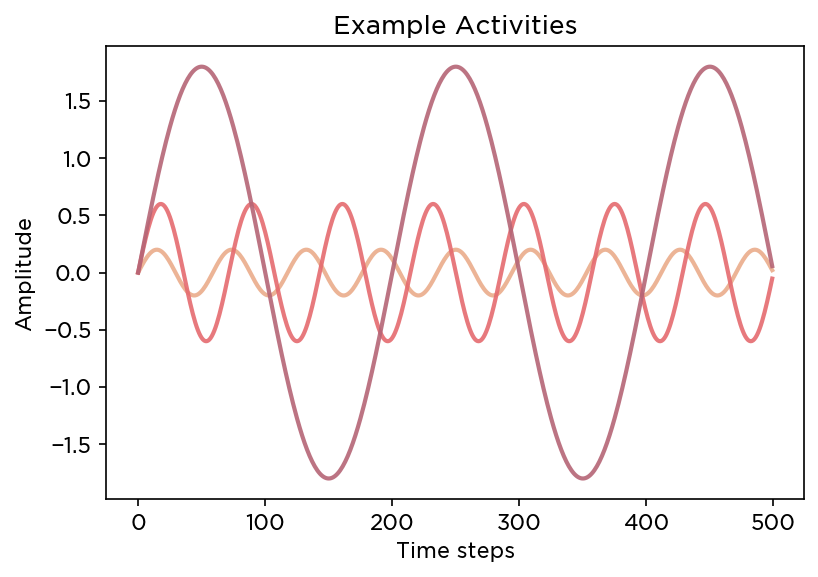

In [265]:
plt.figure(dpi=150)
plt.plot(data[5], label="node 5",c="#EAAC8B",lw=2,alpha=0.9)
plt.plot(data[10], label="node 10",c="#E56B6F",lw=2,alpha=0.9)
plt.plot(data[25], label="node 25",c="#B56576",lw=2,alpha=0.9)
plt.title("Example Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude");

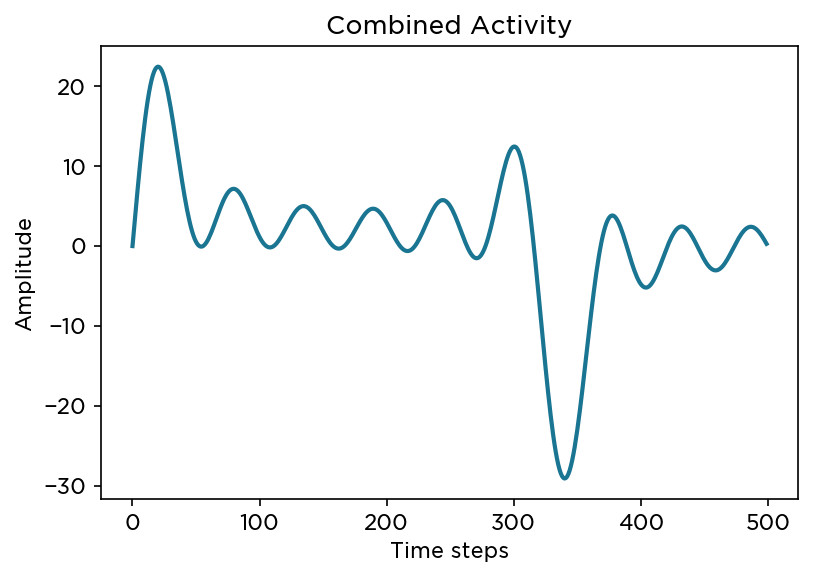

In [266]:
plt.figure(dpi=150)
plt.plot(linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("Combined Activity")
plt.xlabel("Time steps")
plt.ylabel("Amplitude");

In [267]:
shapley_table_linear, _, _ = msa.interface(
    elements=elements,
    n_permutations=10_000,
    objective_function=linear_case,
    n_parallel_games=-1,
    rng=RNG)
linear_modes = shapley_table_linear.groupby(level=1).mean()

Playing the games: 100%|██████████| 234102/234102 [00:04<00:00, 48852.14it/s]


Text(0, 0.5, 'Amplitude')

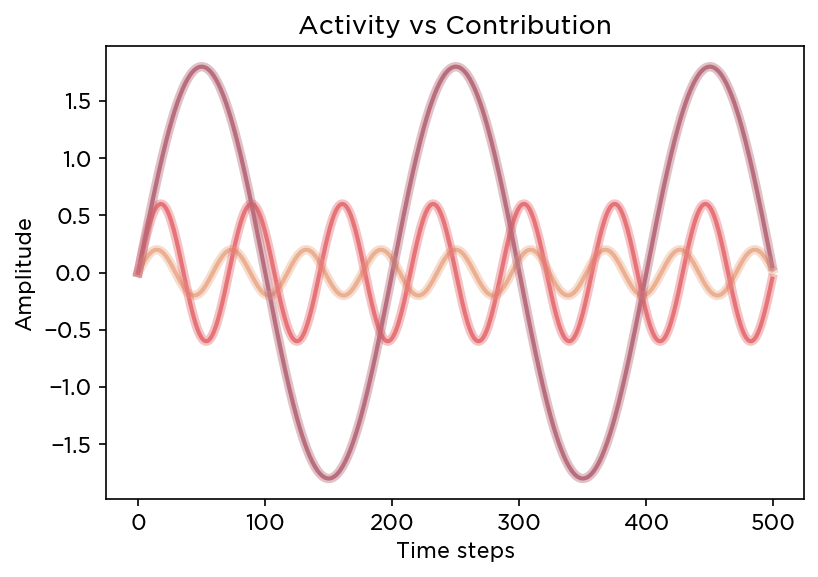

In [268]:
plt.figure(dpi=150)
plt.plot(data[5], label="node 5",c="#EAAC8B",lw=2,alpha=0.9)
plt.plot(data[10], label="node 10",c="#E56B6F",lw=2,alpha=0.9)
plt.plot(data[25], label="node 25",c="#B56576",lw=2,alpha=0.9)

plt.plot(linear_modes[5], label="Contribution #5",c="#EAAC8B",lw=4.5,alpha=0.4)
plt.plot(linear_modes[10], label="Contribution #10",c="#E56B6F",lw=4.5,alpha=0.4)
plt.plot(linear_modes[25], label="Contribution #25",c="#B56576",lw=4.5,alpha=0.4)
plt.title("Activity vs Contribution")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

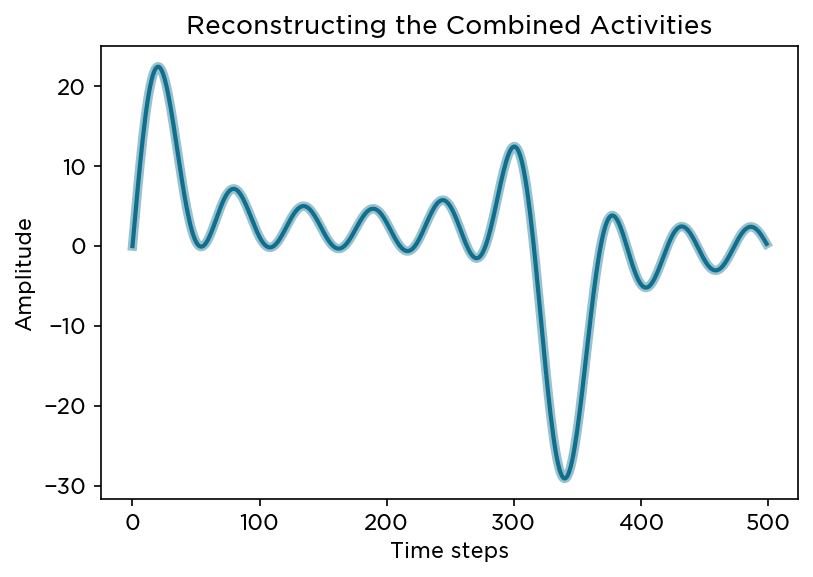

In [269]:
plt.figure(dpi=150)
plt.plot(linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.plot(linear_modes.sum(1),c=my_colors[0],lw=4.5,alpha=0.4)
plt.title("Reconstructing the Combined Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

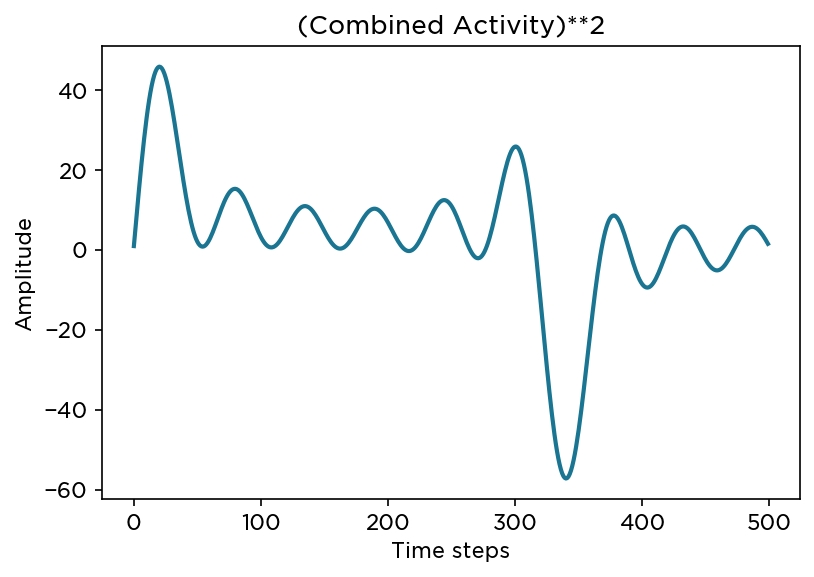

In [274]:
plt.figure(dpi=150)
plt.plot(squared_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("(Combined Activity)**2")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

In [275]:
shapley_table_squared, _, _ = msa.interface(
    elements=elements,
    n_permutations=10_000,
    objective_function=squared_case,
    n_parallel_games=-1,
    rng=RNG)
squared_modes = shapley_table_squared.groupby(level=1).mean()

Playing the games: 100%|██████████| 234153/234153 [00:05<00:00, 41734.20it/s]


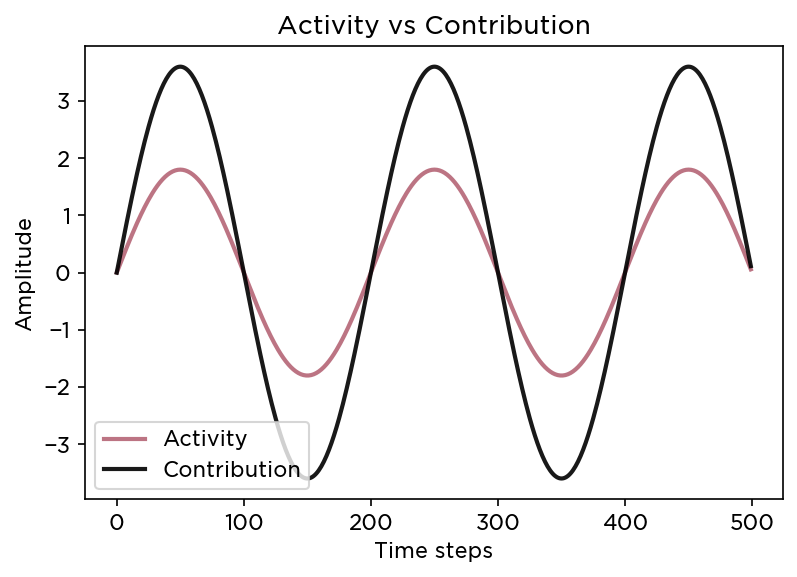

In [276]:
plt.figure(dpi=150)

plt.plot(data[25], label="Activity",c="#B56576",lw=2,alpha=0.9)

plt.plot(squared_modes[25], label="Contribution",c="k",lw=2,alpha=0.9)
plt.title("Activity vs Contribution")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.legend(loc="lower left")

Text(0, 0.5, 'Amplitude')

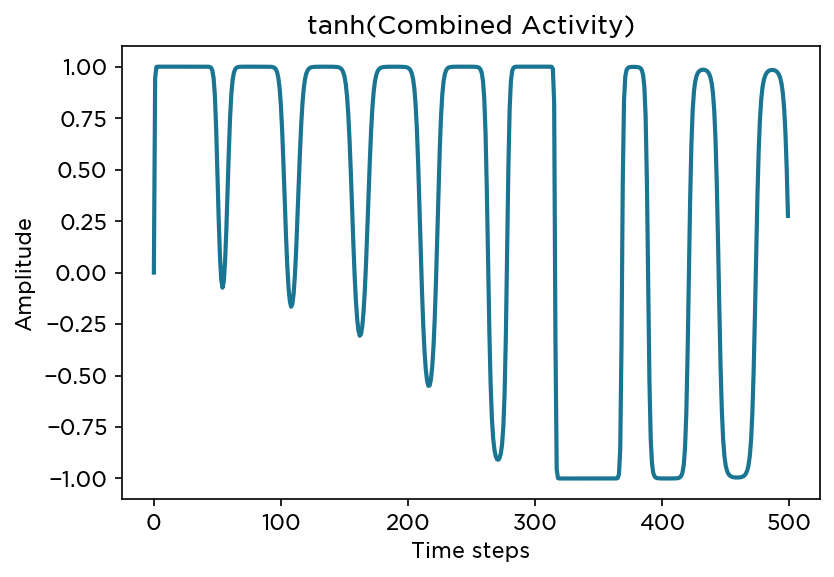

In [277]:
plt.figure(dpi=150)
plt.plot(non_linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("tanh(Combined Activity)")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

In [278]:
shapley_table_nonlinear, _, _ = msa.interface(
    elements=elements,
    n_permutations=10_000,
    objective_function=non_linear_case,
    n_parallel_games=-1,
    rng=RNG)
nonlinear_modes = shapley_table_nonlinear.groupby(level=1).mean()

Playing the games: 100%|██████████| 234254/234254 [00:06<00:00, 35819.34it/s]


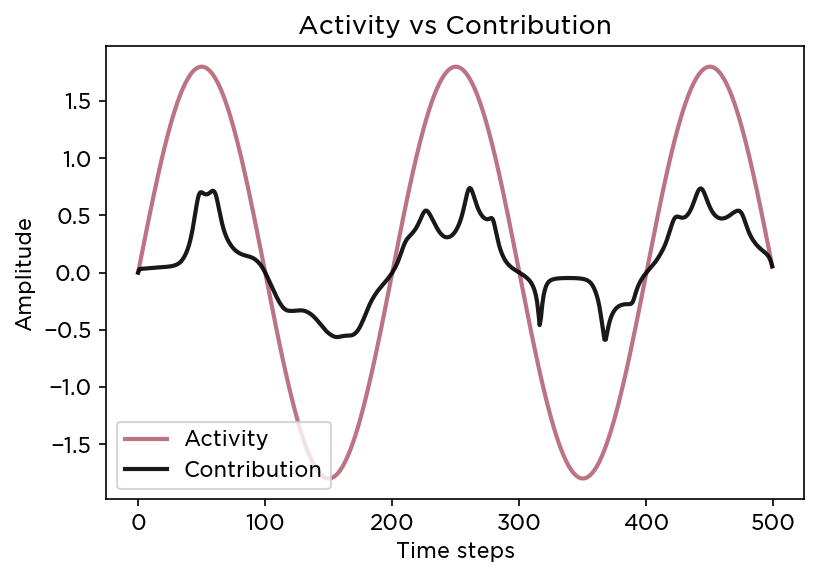

In [279]:
plt.figure(dpi=150)

plt.plot(data[25], label="Activity",c="#B56576",lw=2,alpha=0.9)

plt.plot(nonlinear_modes[25], label="Contribution",c="k",lw=2,alpha=0.9)
plt.title("Activity vs Contribution")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.legend(loc="lower left")

In [145]:
mackey_ts = load_mackeyglasst17()
y_train, y_test = train_test_split(mackey_ts[:2500],
                                   train_size=2000,
                                   test_size=500,
                                   shuffle=False)

y_train_validate, y_test_validate = train_test_split(mackey_ts[:3500],
                                                     train_size=3000,
                                                     test_size=500,
                                                     shuffle=False)
# Constructing connectomes and defining the parameters
rng = np.random.default_rng(seed=SEED)
smallworld = nx.generators.watts_strogatz_graph(36, 6, 0.4, seed=SEED)
connectivity_matrix = nx.to_numpy_array(smallworld)

ser_connectome = connectivity_matrix * rng.uniform(low=0.1,
                                          high=1,
                                          size=(len(connectivity_matrix), len(connectivity_matrix)))

# randomly assigning weights 50 times to have 50 ESN connectomes. This'll make the network more robust.
esn_weights = [connectivity_matrix * rng.uniform(low=-0.5,
                                        high=0.5,
                                        size=(len(connectivity_matrix), len(connectivity_matrix))) for _ in range(50)]

parameter_space = list(ParameterGrid({'radius': np.linspace(0.5, 1, 20),
                                      'W': esn_weights}))
esn = ESNGenerator(n_steps=500,
                   spectral_radius=None,  # to be filled during the hyperparameter tuning
                   leak_rate=0.1,
                   random_state=SEED,
                   W=None,  # to be filled during the hyperparameter tuning
                   W_fb=rng.integers(-1, 1, len(connectivity_matrix)).reshape(-1, 1),
                   W_in=rng.uniform(-1, 1, len(connectivity_matrix)).reshape(-1, 1),
                   bias=0.001)
# Finding the best weights and spectral radius (hyperparameter tuning):
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    esn.spectral_radius = parameters['radius']
    esn.W = parameters['W']
    esn.fit(X=None, y=y_train)
    y_pred = esn.predict()
    parameters.update({'error': mean_squared_error(y_test, y_pred)})

optimum_params = min(parameter_space, key=lambda x: x['error'])  # the combination with the minimum MSE

Optimizing hyperparams: 100%|██████████| 1000/1000 [00:40<00:00, 24.61it/s]


In [209]:
# testing the network.
esn.spectral_radius = optimum_params['radius']
esn.W = optimum_params['W']
esn.store_states_pred=True
esn.fit(X=None, y=y_train_validate)

y_pred = esn.predict()
mse = mean_squared_error(y_test_validate, y_pred)

print(f'MSE: {mse:.2}, Optimal Spectral Radius: {optimum_params["radius"]:.2}')

MSE: 0.0049, Optimal Spectral Radius: 0.66


In [47]:
lesion_esn_params = {'network': esn, 'training_data': y_train_validate}
shapley_table_esn, _, _ = msa.interface(multiprocessing_method='joblib',
                                    elements=list(range(esn.n_reservoir_)),
                                    n_permutations=1_000,
                                    objective_function=lesion_esn,
                                    objective_function_params=lesion_esn_params,
                                    n_parallel_games=-1,
                                    random_seed=SEED)
esn_modes = shapley_table_esn.groupby(level=1).mean()

Playing the games: 100%|██████████| 31953/31953 [01:15<00:00, 424.03it/s]


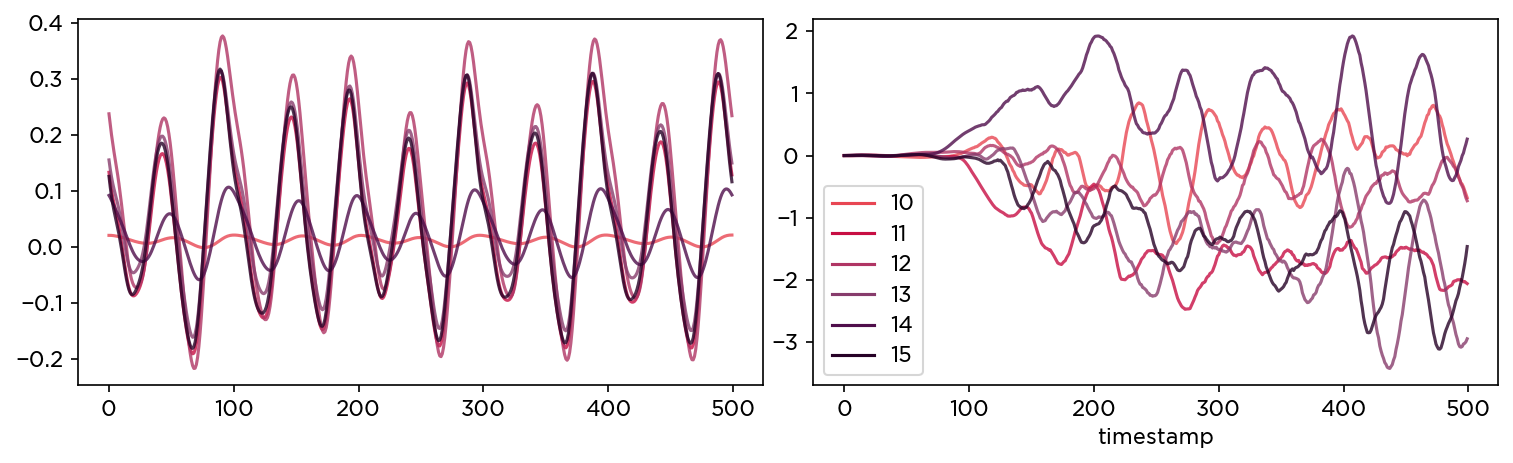

In [49]:
from_to=[10,16]
data_range=esn_modes.T[from_to[0]:from_to[1]]
states_range = esn.states_pred_.T[from_to[0]:from_to[1]]
complementary_colormap = sns.blend_palette(my_complementary_colors, n_colors=len(data_range),as_cmap=False)
fig,axes = plt.subplot_mosaic(
    [['A','B']],figsize=(10,3),dpi=150)
sns.lineplot(data=data_range.T,palette=complementary_colormap,dashes=False,alpha=0.8,legend='brief',ax=axes['B'])
sns.lineplot(data=states_range.T,palette=complementary_colormap,dashes=False,alpha=0.8,legend=False,ax=axes['A'])


fig.tight_layout(pad=0.4)

In [227]:
from sklearn.feature_selection import mutual_info_regression as mi
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr, pearsonr

In [218]:
transformation_index = [float(mi(np.array(esn.states_pred_.T[i]).reshape(-1, 1),
                                 np.array(esn_modes[i]).reshape(-1, 1).squeeze())) for i in range(len(esn_modes.T))]

In [286]:
similarity_index = [float(cosine(np.array(esn.states_pred_.T[i]),np.array(esn_modes[i]))) for i in range(len(esn_modes.T))]
similarity_index= -(np.array(similarity_index) -1)

In [287]:
similarity_index

array([ 0.52720123, -0.11982756,  0.17814544,  0.19592093,  0.23069507,
       -0.5429905 , -0.34085655, -0.49719146,  0.47406964, -0.66168821,
        0.00860735, -0.26114661, -0.3800872 , -0.44797458,  0.25596352,
       -0.30694976,  0.59404115,  0.37542065,  0.23849036, -0.33414771,
       -0.48109316,  0.40777401,  0.38029389,  0.52673229, -0.10438174,
        0.19133615, -0.42997894,  0.39402741, -0.41824122, -0.2772173 ,
       -0.13504584,  0.09733804,  0.78317976, -0.38057758, -0.1863753 ,
        0.25274552])

In [52]:
modes_similarities = np.array(esn_modes.corr())
fc = np.corrcoef(esn.states_pred_.T)

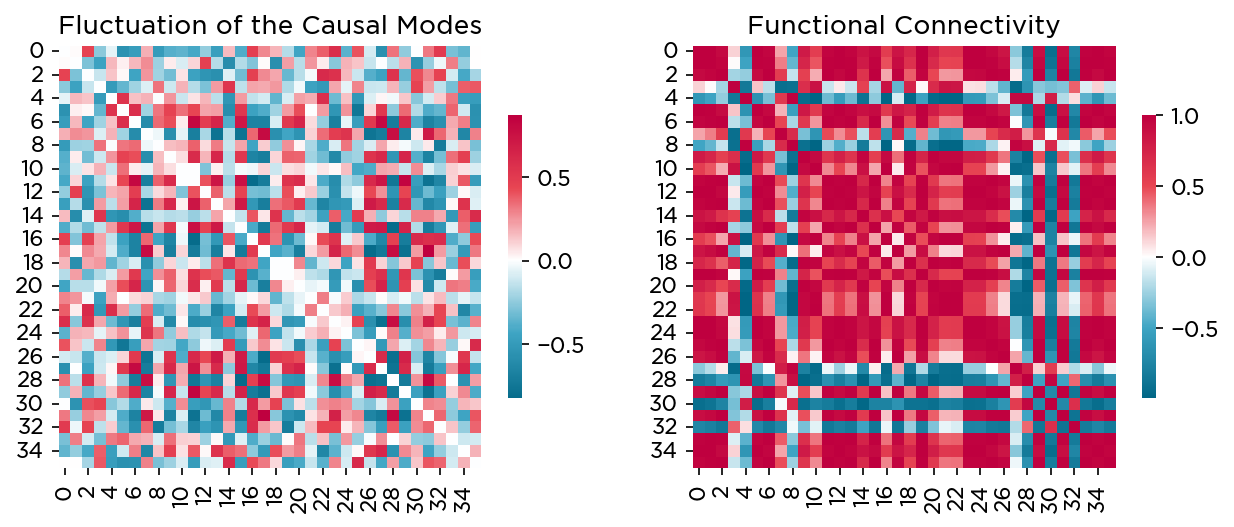

In [289]:
fig,axes = plt.subplot_mosaic(
    [['A','B']],figsize=(10,5),dpi=150)
sns.heatmap(modes_similarities,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},ax=axes['A'],linewidths=0., linecolor='k')
sns.heatmap(fc,square=True,
            cmap=colormap,center=0,cbar_kws={"shrink": .5},ax=axes['B'],linewidths=0., linecolor='k')
axes['A'].title.set_text('Fluctuation of the Causal Modes')
axes['B'].title.set_text('Functional Connectivity')

In [72]:
gamma = 1.
mode_communities = [bct.clustering.modularity_louvain_und_sign(modes_similarities, gamma=gamma)[0] for _ in range(1000)]
mode_consensus = cluster.find_consensus(np.column_stack(mode_communities), seed=SEED)
fc_communities = [bct.clustering.modularity_louvain_und_sign(fc, gamma=gamma)[0] for _ in range(1000)]
fc_consensus = cluster.find_consensus(np.column_stack(fc_communities), seed=SEED)


<AxesSubplot:label='B'>

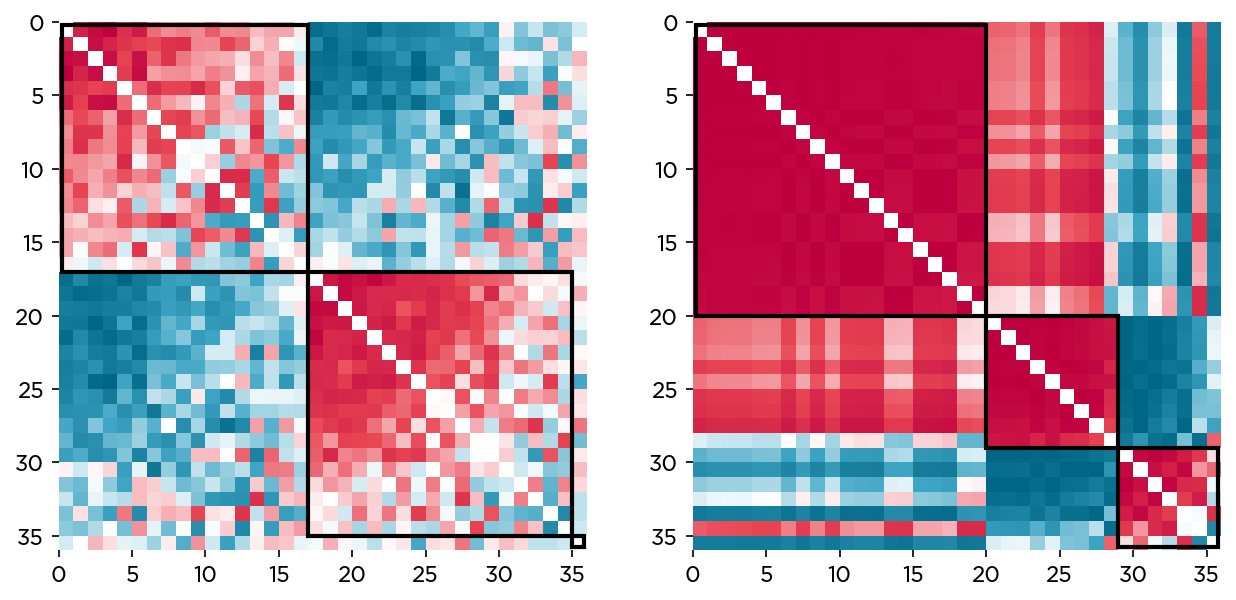

In [75]:
fig,axes = plt.subplot_mosaic([['A','B']],figsize=(10,5),dpi=150)
netplot.plot_mod_heatmap(modes_similarities, mode_consensus, cmap=colormap,ax=axes['A'],cbar=False)
netplot.plot_mod_heatmap(fc, fc_consensus, cmap=colormap,ax=axes['B'],cbar=False,)

In [133]:
nonnegative_modes = modes_similarities.copy()
nonnegative_modes[modes_similarities<0] = 0

nonnegative_fc = fc.copy()
nonnegative_fc[fc<0] = 0

In [246]:
positive_signed_degree = (modes_similarities>0).sum(axis=0)/len(modes_similarities)

In [284]:
similarity_index

[0.47279877076058385,
 1.1198275645864206,
 0.8218545594298156,
 0.804079068406754,
 0.7693049342643093,
 1.5429904972343707,
 1.3408565506260293,
 1.4971914633152479,
 0.5259303586275615,
 1.6616882083417335,
 0.991392652128278,
 1.2611466085853156,
 1.3800871964070995,
 1.4479745788234921,
 0.7440364764191885,
 1.3069497648919826,
 0.4059588455997396,
 0.6245793546889731,
 0.7615096433135786,
 1.3341477090912726,
 1.4810931619284387,
 0.5922259913463679,
 0.6197061086080852,
 0.4732677135017388,
 1.1043817354771,
 0.8086638479587472,
 1.4299789386432398,
 0.6059725932705471,
 1.4182412187164828,
 1.277217303046422,
 1.1350458372640846,
 0.9026619649700656,
 0.21682023969265762,
 1.3805775824696473,
 1.1863752996364005,
 0.7472544766009075]

/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SpearmanrResult(correlation=-0.424967824967825, pvalue=0.009777858615602751)

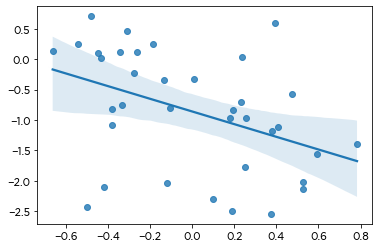

In [288]:
test=modes_similarities.sum(axis=1)
sns.regplot(similarity_index,test)
spearmanr(similarity_index,test)

/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SpearmanrResult(correlation=0.01904761904761905, pvalue=0.9122014112003571)

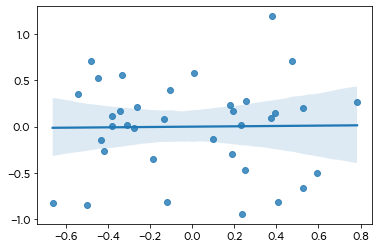

In [292]:
sns.regplot(similarity_index,esn.W_out_.squeeze()[:-1]/3000)
spearmanr(similarity_index,esn.W_out_.squeeze()[:-1]/3000)

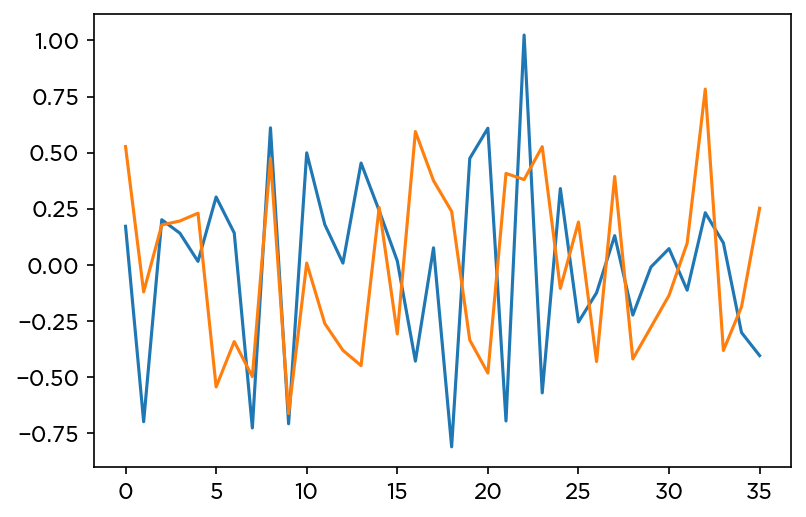

In [305]:
plt.figure(dpi=150)
plt.plot(esn.W_out_.squeeze()[:-1]/3500)
plt.plot(similarity_index)
#plt.plot(esn_modes.mean(0))

/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SpearmanrResult(correlation=-0.19922779922779926, pvalue=0.24405807168627947)

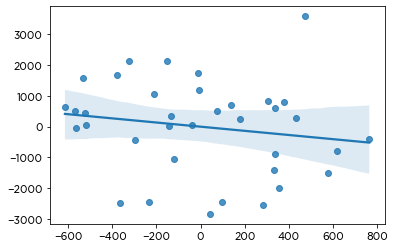

In [294]:
sns.regplot(esn_modes.sum(0),esn.W_out_.squeeze()[:-1])
spearmanr(esn_modes.sum(0),esn.W_out_.squeeze()[:-1])

In [293]:
esn_modes.sum(0).shape

(36,)

/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SpearmanrResult(correlation=0.3250965250965251, pvalue=0.05303245768981318)

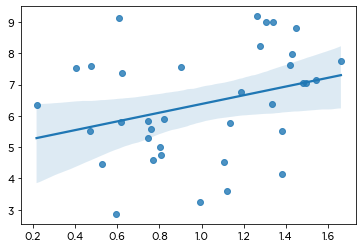

In [233]:
sns.regplot(similarity_index,nonnegative_modes.sum(axis=0))
spearmanr(similarity_index,nonnegative_modes.sum(axis=0))

<AxesSubplot:ylabel='Count'>

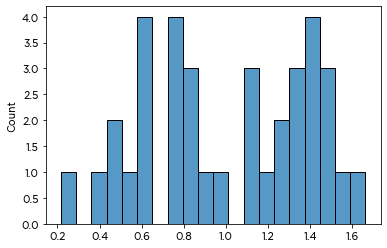

In [282]:
sns.histplot(similarity_index,bins=20)